# 推荐系统

首先对音乐数据集进行数据清洗和特征提取，基于矩阵分解方式来进行音乐推荐。

- 音乐数据处理

读取音乐数据集，并统计其各项指标，选择有价值的信息当做我们的特征

- 基于商品相似性的推荐 

选择相似度计算方法，通过相似度来计算推荐结果

- 基于SVD矩阵分解的推荐

使用矩阵分解方法，快速高效得到推荐结果

In [1]:
#导入相关的数据库和数据集
import pandas as pd
import numpy as np
import time
import sqlite3
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
data_home = './'

## 数据读取

在数据中只需要用户，歌曲，播放量

In [2]:
#提取数据集中有用的部分  uesr  song  play_count
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt', 
                              sep='\t', header=None, 
                              names=['user','song','play_count'])

In [3]:
triplet_dataset.info()#查看数据类型等信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        object
 1   song        object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ GB


数据规模还是蛮大的

In [4]:
# label编码
user_encoder = LabelEncoder()
triplet_dataset['user'] = user_encoder.fit_transform(triplet_dataset['user'].values)

song_encoder = LabelEncoder()
triplet_dataset['song'] = song_encoder.fit_transform(triplet_dataset['song'].values)


# 数据类型转换
triplet_dataset.astype({'user': 'int32', 'song': 'int32', 'play_count': 'int32'})

,user,song,play_count
0,732659,6347,1
1,732659,9365,1
2,732659,16962,2
3,732659,19513,1
4,732659,19536,1
...,...,...,...
48373581,730666,306720,2
48373582,730666,308056,1
48373583,730666,312743,1
48373584,730666,343652,3


In [5]:
triplet_dataset.shape#查看数据形状

(48373586, 3)

数据占用内存与各指标格式

In [6]:
triplet_dataset.info()#查看数据类型等信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   user        int32
 1   song        int32
 2   play_count  int64
dtypes: int32(2), int64(1)
memory usage: 738.1 MB


原始数据

In [7]:
triplet_dataset.head(n=10)#查看前10条数据

,user,song,play_count
0,732659,6347,1
1,732659,9365,1
2,732659,16962,2
3,732659,19513,1
4,732659,19536,1
5,732659,24689,1
6,732659,27760,2
7,732659,29262,1
8,732659,30363,1
9,732659,30512,1


## 对每一个用户，分别统计他的播放总量

数据中有用户的编号，歌曲编号，已经用户对该歌曲播放的次数。
有了基础数据之后，我们还可以统计出关于用户与歌曲的各项指标，例如对每一个用户，分别统计他的播放总量，代码如下：

In [8]:
#对数据进行简单统计
#创建一个空字典
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #找到当前的用户
        user = line.split('\t')[0]
        #得到其播放量数据
        play_count = int(line.split('\t')[2])
        #如果字典中已经有该用户信息，在其基础上增加当前的播放量
        if user in output_dict:
            play_count +=output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
# 统计 用户-总播放量
output_list = [{'user':k,'play_count':v} for k,v in output_dict.items()]
#转换成DF格式
play_count_df = pd.DataFrame(output_list)
#排序
play_count_df = play_count_df.sort_values(by = 'play_count', ascending = False)

In [9]:
#保存数据
play_count_df.to_csv(path_or_buf='user_playcount_df.csv', index = False)

## 对于每一首歌，分别统计它的播放总量

In [10]:
#统计方法跟上述类似
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        #找到当前歌曲
        song = line.split('\t')[1]
        #找到当前播放次数
        play_count = int(line.split('\t')[2])
        #统计每首歌曲被播放的总次数
        if song in output_dict:
            play_count +=output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
#转换成df格式
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by = 'play_count', ascending = False)

In [11]:
song_count_df.to_csv(path_or_buf='song_playcount_df.csv', index = False)

In [12]:
play_count_df.head()

,user,play_count
669980,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
402687,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
964856,3fa44653315697f42410a30cb766a4eb102080bb,8210
462404,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
991089,d7d2d888ae04d16e994d6964214a1de81392ee04,6494


## 看看目前的排行情况

In [13]:
#读取数据(用户-播放次数)
play_count_df = pd.read_csv(filepath_or_buffer='user_playcount_df.csv')
play_count_df.head(n =10)#查看前十条数据

,user,play_count
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
1,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
2,3fa44653315697f42410a30cb766a4eb102080bb,8210
3,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
4,d7d2d888ae04d16e994d6964214a1de81392ee04,6494
5,4ae01afa8f2430ea0704d502bc7b57fb52164882,6472
6,b7c24f770be6b802805ac0e2106624a517643c17,6150
7,113255a012b2affeab62607563d03fbdf31b08e7,5656
8,6d625c6557df84b60d90426c0116138b617b9449,5620
9,99ac3d883681e21ea68071019dba828ce76fe94d,5602


In [14]:
#读取数据(歌曲-播放次数)
song_count_df = pd.read_csv(filepath_or_buffer='song_playcount_df.csv')
song_count_df.head(10)#查看前十条数据

,song,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880
5,SOAXGDH12A8C13F8A1,356533
6,SONYKOW12AB01849C9,292642
7,SOPUCYA12A8C13A694,274627
8,SOUFTBI12AB0183F65,268353
9,SOVDSJC12A58A7A271,244730


最受欢迎的一首歌曲有726885次播放。
刚才大家也看到了，这个音乐数据量集十分庞大，考虑到执行过程的时间消耗以及矩阵稀疏性问题，我们依据播放量指标对数据集进行了截取。因为有些注册用户可能只是关注了一下之后就不再登录平台，这些用户对我们建模不会起促进作用，反而增大了矩阵的稀疏性。对于歌曲也是同理，可能有些歌曲根本无人问津。由于之前已经对用户与歌曲播放情况进行了排序，所以我们分别选择了其中的10W名用户和1W首歌曲，关于截取的合适比例大家也可以通过观察选择数据的播放量占总体的比例来设置。

## 取其中一部分数（按大小排好序的了，这些应该是比较重要的数据），作为我们的实验数据

In [15]:
#10W名用户的播放量占总体的比例
total_play_count = sum(song_count_df.play_count)#求和
print ((float(play_count_df.head(n=200000).play_count.sum())/total_play_count)*100)#查看比例
play_count_subset = play_count_df.head(n=200000)

59.249552223527616


In [16]:
(float(song_count_df.head(n=10000).play_count.sum())/total_play_count)*100#1w歌曲占总歌曲的比例

59.09176046078892

In [17]:
song_count_subset = song_count_df.head(n=10000)

前1W首歌的播放量占到了总体的59.09%
现在已经有了这10W名忠实用户和1W首经典歌曲，接下来我们就要对原始数据集进行过滤清洗，说白了就是在原始数据集中剔除掉不包含这些用户以及歌曲的数据。

取10W个用户，1W首歌

In [18]:
#建立歌曲和客户的列表1w，10w
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)

过滤掉其他用户数据

In [19]:
#读取原始数据集
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt',sep='\t', 
                              header=None, names=['user','song','play_count'])
#只保留有这10W名用户的数据，其余过滤掉
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset) ]
del(triplet_dataset)
#只保留有这1W首歌曲的数据，其余也过滤掉
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub)

In [20]:
triplet_dataset_sub_song.to_csv(path_or_buf=data_home+'triplet_dataset_sub_song.csv', index=False)#保存数据

当前我们的数据量

In [21]:
triplet_dataset_sub_song.shape#查看数据类型

(11853277, 3)

In [22]:
triplet_dataset_sub_song.head(n=10)#查看前10条数据

,user,song,play_count
362,17aa9f6dbdf753831da8f38c71b66b64373de613,SOACPBY12A8C13FEF9,1
363,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAKHOF12A8C13C72A,2
364,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAVIJW12AB018269B,1
366,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBDVAK12AC90759A2,1
367,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBGMYK12A6D4F6730,1
368,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBIMTY12A6D4F931F,1
369,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBKRVG12A8C133269,1
370,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBUBLL12A58A795A8,1
371,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBVKFF12A8C137A79,1
373,17aa9f6dbdf753831da8f38c71b66b64373de613,SOCHAXM12AB01876F8,1


## 加入音乐详细信息

我们目前拿到的数据只有播放次数，可利用的信息实在太少了，对每首歌来说正常情况都应该有一份详细信息，例如歌手，发布时间，主题等，这些信息都存在一份数据库格式文件中，接下来我们就通过sqlite工具包来读取这些数据：

In [23]:
conn = sqlite3.connect(data_home+'track_metadata.db')#链接db数据库
cur = conn.cursor()#使用连接对象获得一个cursor对象
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")#查看库里的表
cur.fetchall()#返回记录

[('songs',)]

In [24]:
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')#使用pd读取sql数据库  数据song
track_metadata_df_sub = track_metadata_df[track_metadata_df.song_id.isin(song_subset)]

In [25]:
track_metadata_df_sub.to_csv(path_or_buf=data_home+'track_metadata_df_sub.csv', index=False)#保存数据

In [26]:
track_metadata_df_sub.shape#查看数据类型

(10263, 14)

## 我们现有的数据

In [27]:
#读取song数据
triplet_dataset_sub_song = pd.read_csv(filepath_or_buffer=data_home+'triplet_dataset_sub_song.csv',encoding = "ISO-8859-1")#拼接表
track_metadata_df_sub = pd.read_csv(filepath_or_buffer=data_home+'track_metadata_df_sub.csv',encoding = "ISO-8859-1")

In [28]:
triplet_dataset_sub_song.head()#查看前几条数据

,user,song,play_count
0,17aa9f6dbdf753831da8f38c71b66b64373de613,SOACPBY12A8C13FEF9,1
1,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAKHOF12A8C13C72A,2
2,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAVIJW12AB018269B,1
3,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBDVAK12AC90759A2,1
4,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBGMYK12A6D4F6730,1


In [29]:
track_metadata_df_sub.head()#查看前几条数据

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
1,TRMMCDR128F423AB03,Anyone Else But You,SOSZNRJ12A8AE46E38,Juno - Music From The Motion Picture,AR62GN71187B9AAD0C,70fada2a-5b8c-4988-a2d7-79576d7f6daf,Michael Cera & Ellen Page,116.71465,0.540441,0.464981,2007,2028040,-1,0
2,TRMMFSL128F4234583,Drunk and Hot Girls,SOGKGLB12A81C22AFA,Graduation,ARRH63Y1187FB47783,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West / Mos Def,313.28608,0.877214,1.082503,2007,1356708,-1,0
3,TRMMQSP128F1486267,Until The Day I Die (Album Version),SOWZDNH12A6D4F7237,Page Avenue,ARF6ZTO1187FB3684F,e2c3c508-f0ab-49af-92c9-a81d66d67405,Story Of The Year,235.78077,0.806763,0.580095,2003,471119,-1,0
4,TRMMQOL128F9340687,Rewind (Demo),SOQBGZD12AB0184341,Riot!,AR4OU721187FB4549D,728ea90d-279b-4201-a8c4-597830883150,Paramore,226.95138,0.951488,0.658925,0,5669453,-1,0


## 清洗数据集

去除掉无用的和重复的，数据清洗是很重要的一步

In [30]:
# 去掉无用的信息
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])
# 去掉重复的
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])
# 将这份音乐信息数据和我们之前的播放数据整合到一起
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song, track_metadata_df_sub, how='left', left_on='song', right_on='song_id')
# 可以自己改变列名
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)

In [31]:
# 去掉不需要的指标
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

搞定数据，来看看它长什么样子吧

In [32]:
triplet_dataset_sub_song_merged.head(n=10)

,user,song,listen_count,title,release,artist_name,year
0,17aa9f6dbdf753831da8f38c71b66b64373de613,SOACPBY12A8C13FEF9,1,Full Circle,Breakout,Miley Cyrus,2008
1,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAKHOF12A8C13C72A,2,Poor Jackie,Rabbit Habits,Man Man,2008
2,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAVIJW12AB018269B,1,Hot N Cold (Manhattan Clique Remix Radio Edit),Hot N Cold,Katy Perry,2008
3,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBDVAK12AC90759A2,1,Daisy And Prudence,Distillation,Erin McKeown,2000
4,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBGMYK12A6D4F6730,1,Everythings Just Wonderful,Alright_ Still,Lily Allen,0
5,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBIMTY12A6D4F931F,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
6,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBKRVG12A8C133269,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
7,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBUBLL12A58A795A8,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
8,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBVKFF12A8C137A79,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007
9,17aa9f6dbdf753831da8f38c71b66b64373de613,SOCHAXM12AB01876F8,1,Bleeding Hearts,Hell Train,Soltero,0


### 展示最流行的歌曲

                                                  title  listen_count
9502                                     You're The One        392366
8732                                               Undo        315463
6523                                            Revelry        273441
6861                                      Sehr kosmisch        198010
3447  Horn Concerto No. 4 in E flat K495: II. Romanc...        195978
1954                     Dog Days Are Over (Radio Edit)        185272
1253                                             Canada        166499
4049                                            Invalid        151085
6846                                            Secrets        150735
1307  Catch You Baby (Steve Pitron & Max Sanna Radio...        133184
6505                                        ReprÃ©sente        132968
241                                    Ain't Misbehavin        131778
7084                             SinceritÃ© Et Jalousie        123785
7989                

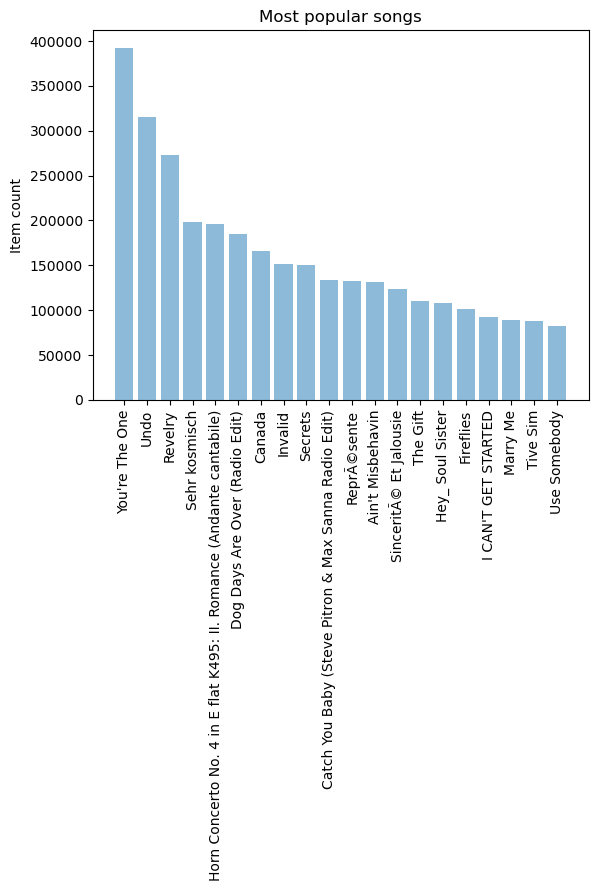

In [35]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#按歌曲名字来统计其播放量的总数
popular_songs = triplet_dataset_sub_song_merged[['title','listen_count']].groupby('title').sum().reset_index()

#对结果进行排序
popular_songs_top_20 = popular_songs.sort_values('listen_count', ascending=False).head(n=20)
print(popular_songs_top_20)
#转换成list格式方便画图
objects = (list(popular_songs_top_20['title']))
#设置位置
y_pos = np.arange(len(objects))
#对应结果值
performance = list(popular_songs_top_20['listen_count'])
#绘图
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular songs')
 
plt.show()

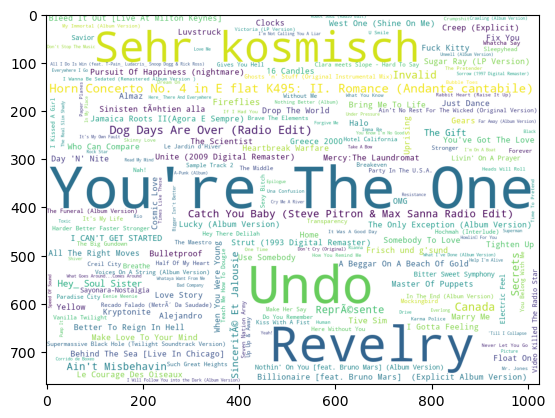

In [34]:
gequ = dict(zip(popular_songs['title'],popular_songs['listen_count']))#建立一个歌曲的字典
#导入库
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 设置格式
wc = WordCloud(width=1024, height=768, background_color='white', max_font_size=400, random_state=50)
# 从频率字典中生成词云
wc.generate_from_frequencies(gequ)
plt.imshow(wc)
plt.show()

这里展示了最受欢迎的歌曲，使用groupby函数可以很方便的对每首歌曲统计其播放情况，我们求的是总和也就是总播放量。这份排行数据就可以当做最受欢迎歌曲来推荐给用户了。
同样的方法我们还可以对专辑和歌手的播放情况分别进行统计：

### 最受欢迎的releases

                               release  listen_count
2350                If There Was A Way        385546
1978                     Greatest Hits        364730
3552                 Only By The Night        321656
5675                   Vespertine Live        317178
3308                         My Worlds        251826
5733                         Waking Up        239497
3448  Now That's What I Call Music! 75        225022
4136            Save Me_ San Francisco        219082
3270                Musik von Harmonia        198010
3227   Mozart - Eine kleine Nachtmusik        195978
2969                             Lungs        188417
1661                     Fat Come Back        169286
4914                   The End Is Here        166499
1684                     Fermi Paradox        151085
4937                  The Fame Monster        140695
896                     Catch You Baby        133184
4572                        Summertime        131778
198        A Rush Of Blood To The Head        

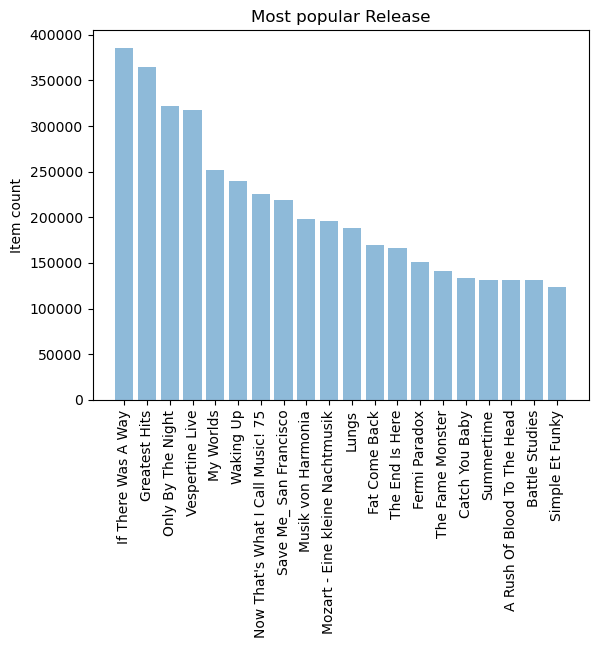

In [36]:
#按专辑名字来统计播放总量
popular_release = triplet_dataset_sub_song_merged[['release','listen_count']].groupby('release').sum().reset_index()
#排序
popular_release_top_20 = popular_release.sort_values('listen_count', ascending=False).head(n=20)
print(popular_release_top_20)
objects = (list(popular_release_top_20['release']))
y_pos = np.arange(len(objects))
performance = list(popular_release_top_20['listen_count'])
#绘图 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Release')
 
plt.show()

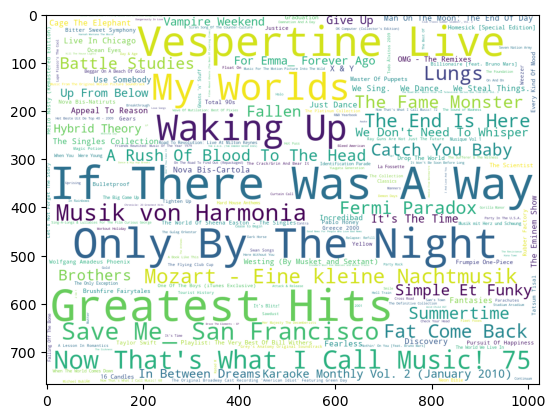

In [36]:
release = dict(zip(popular_release['release'],popular_release['listen_count']))#建立一个专辑的字典

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 设置格式
wc = WordCloud(width=1024, height=768, background_color='white', max_font_size=400, random_state=50)
# 从频率字典中生成词云
wc.generate_from_frequencies(release)
plt.imshow(wc)
plt.show()

## 最受欢迎的歌手

                 artist_name  listen_count
780                 Coldplay        591661
1976           Kings Of Leon        497853
3406          The Black Keys        457081
1325  Florence + The Machine        446044
1099           Dwight Yoakam        385546
1649            Jack Johnson        360284
421                   BjÃ¶rk        343641
2482                    Muse        299467
3523             The Killers        298321
144          Alliance Ethnik        293071
2630             OneRepublic        288886
2839               Radiohead        279522
1868           Justin Bieber        274663
3786                   Train        273138
2112             Linkin Park        270486
882                Daft Punk        244077
1777              John Mayer        240225
2361               Metallica        236226
1178                  Eminem        216012
3350            Taylor Swift        211838


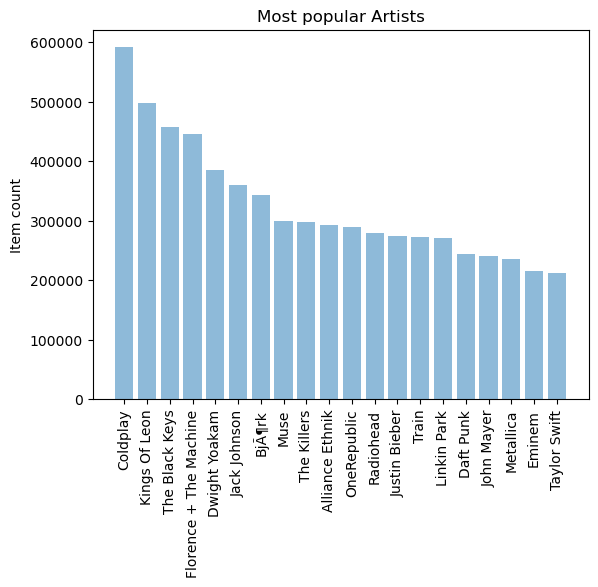

In [37]:
#按歌手来统计其播放总量
popular_artist = triplet_dataset_sub_song_merged[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
#排序
popular_artist_top_20 = popular_artist.sort_values('listen_count', ascending=False).head(n=20)
print(popular_artist_top_20)
objects = (list(popular_artist_top_20['artist_name']))
y_pos = np.arange(len(objects))
performance = list(popular_artist_top_20['listen_count'])
#绘图 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Artists')
 
plt.show()

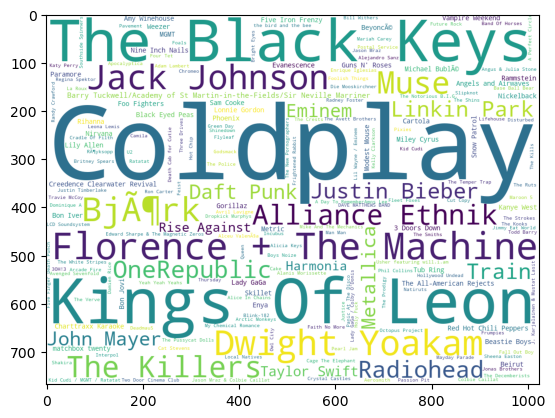

In [38]:
artist = dict(zip(popular_artist['artist_name'],popular_artist['listen_count']))#建立一个歌手的字典

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 设置格式
wc = WordCloud(width=1024, height=768, background_color='white', max_font_size=400, random_state=50)
# 从频率字典中生成词云
wc.generate_from_frequencies(artist)
plt.imshow(wc)
plt.show()

## 用户播放过歌曲量的分布

In [39]:
user_song_count_distribution = triplet_dataset_sub_song_merged[['user','title']].groupby('user').count().reset_index().sort_values(
by='title',ascending = False)#根据user生成一张表
user_song_count_distribution.title.describe()#查看表分析

count    199909.000000
mean         59.293363
std          46.539485
min           1.000000
25%          28.000000
50%          48.000000
75%          76.000000
max         820.000000
Name: title, dtype: float64

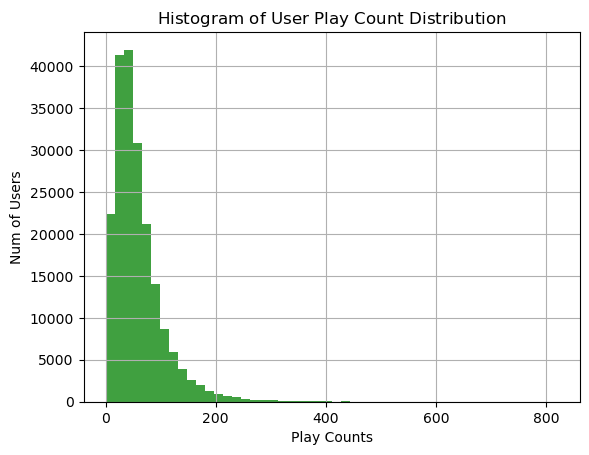

In [40]:
#查看用户播放过歌曲量的分布
x = user_song_count_distribution.title
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'$\mathrm{Histogram\ of\ User\ Play\ Count\ Distribution}\ $')
plt.grid(True)
plt.show()

绝大多数用户播放歌曲的数量在100左右，关于数据的处理和介绍已经给大家都分析过了，接下来我们要做的就是构建一个能实际进行推荐的程序了。

## 开始构建推荐系统

In [41]:
import Recommenders as Recommenders#导入库
from sklearn.model_selection import train_test_split

## 简单暴力，排行榜单推荐，对新用户来说解决冷启动问题

最简单的推荐方式就是排行榜单了，这里我们创建了一个函数，需要我们传入的是原始数据，用户列名，待统计的指标（例如按歌曲名字，歌手名字，专辑名字。选择统计哪项指标得到的排行榜单）：

In [42]:
triplet_dataset_sub_song_merged_set = triplet_dataset_sub_song_merged
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_set, test_size = 0.40, random_state=0)

In [43]:
train_data.head()

,user,song,listen_count,title,release,artist_name,year
4316468,2b5a1eaccba7e71ad3452c9d8b3465b739a3d809,SOKBRAQ12A6D4F8FEC,2,Stripper Vicar,Legacy: The Best Of Mansun,Mansun,1996
2360486,25a862514995cd4014b920aa1c71706a1f21a22f,SOGTUTL12A8C138C32,2,Heart,Heart,Stars,2002
1405006,3147b8f656e2186d9fc7938e92639e58682a7044,SOBJQMP12A8C141CF2,12,Aunque Estes Con El,Palabras Del Silencio,Luis Fonsi,2008
8718090,8082ed8a6172a6c981548c3fb74bdb1123649246,SOIFGCB12A8C134160,7,Mushaboom,Cool - Chillout,Feist,2005
11716413,c135d3ea755b305274e51cbe79cac183838e7394,SOTARUJ12A8C13B0DA,1,Six Feet Up,One Ten Hundred Thousand Million,Octopus Project,2005


In [44]:
def create_popularity_recommendation(train_data, user_id, item_id):
    #根据指定的特征来统计其播放情况，可以选择歌曲名，专辑名，歌手名
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    #为了直观展示，我们用得分来表示其结果
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #排行榜单需要排序
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #加入一项排行等级，表示其推荐的优先级
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    #返回指定个数的推荐结果
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [45]:
#建立一张表，包含title score rank
recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')

得到推荐结果

In [46]:
recommendations#查看结果

,title,score,Rank
6861,Sehr kosmisch,34011,1.0
1954,Dog Days Are Over (Radio Edit),31432,2.0
9502,You're The One,28925,3.0
8732,Undo,27251,4.0
6846,Secrets,26984,5.0
6523,Revelry,26819,6.0
2599,Fireflies,22828,7.0
3335,Hey_ Soul Sister,22781,8.0
3447,Horn Concerto No. 4 in E flat K495: II. Romanc...,22235,9.0
8782,Use Somebody,21332,10.0


返回了一份前20的歌曲排行榜单，其中的得分这里只是进行了简单的播放计算，在设计的时候也可以综合考虑更多的指标，比如综合计算歌曲发布年份，歌手的流行程度等。

## 基于歌曲相似度的推荐

接下来就要进行相似度的计算来推荐歌曲了，为了加快代码的运行速度，选择了其中一部分数据来进行实验。

In [47]:
song_count_subset = song_count_df.head(n=5000)#选取5000的歌曲信息来继续相似度推荐
user_subset = list(play_count_subset.user)#建立user列表
song_subset = list(song_count_subset.song)#建立song列表
triplet_dataset_sub_song_merged_sub = triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]#整合上面的表

In [48]:
triplet_dataset_sub_song_merged_sub.head()#查看新表信息

,user,song,listen_count,title,release,artist_name,year
2,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAVIJW12AB018269B,1,Hot N Cold (Manhattan Clique Remix Radio Edit),Hot N Cold,Katy Perry,2008
3,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBDVAK12AC90759A2,1,Daisy And Prudence,Distillation,Erin McKeown,2000
4,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBGMYK12A6D4F6730,1,Everythings Just Wonderful,Alright_ Still,Lily Allen,0
5,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBIMTY12A6D4F931F,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
6,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBKRVG12A8C133269,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007


### 计算相似度得到推荐结果

In [49]:
import Recommenders as Recommenders
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_sub, test_size = 0.30, random_state=0)#划分训练集与测试集
is_model = Recommenders.item_similarity_recommender_py()#执行推荐 基于歌曲流行度的推荐 建立一个模型
is_model.create(train_data, 'user', 'title')#传入原始数据、用户ID和歌曲信息
user_id = list(train_data.user)[7]
user_items = is_model.get_user_items(user_id)

心的同学应该观察到了，我们首先导入了Recommenders，像是一个自定义的工具包，这里就包括了我们接下来要使用的所有函数，由于接下来进行计算的代码量较大，直接在notebook中进行展示比较麻烦，所有我们自己写了一个.py文件，所有的实际计算操作都在这里完成了。
大家在实践这份代码的时候，可以选择一个合适的IDE，因为notebook并不支持debug操作。拿到了一份陌生的代码而且量又比较大的时候，最好先通过debug的方式一行代码一行代码来执行，这样可以更清晰的熟悉整个函数做了一件什么事，如果直接看整体对于初学的同学们来说可能会有点难度，建议大家选择一个趁手的IDE例如pycharm,eclipse等都是不错的。

整体的代码量还是比较多，我先从整体上介绍这段代码做了一件什么事，大家在自己玩的时候最好按照我之前说的还是debug一遍更舒服。首先我们要针对某一个用户进行推荐，那必然得先得到他都听过哪些歌曲，通过这些已被听过的歌曲跟整个数据集中的歌曲进行对比，看哪些歌曲跟用户已听过的比较类似，推荐的就是这些类似的。如何计算呢？例如当前用户听过了66首歌曲，整个数据集中有4879个歌曲，我们要做的就是构建一个[66,4879]的矩阵，其中每一个值表示用户听过的每一个歌曲和数据集中每一个歌曲的相似度。这里使用Jaccard相似系数，矩阵中[i,j]的含义就是用户听过的第i首歌曲这些歌曲被哪些人听过，比如有3000人听过，数据集中的j歌曲被哪些人听过，比如有5000人听过。Jaccard相似系数就要求：

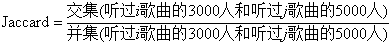

说白了就是如果两个歌曲很相似，那其受众应当是一致的，交集/并集的比例应该比较大，如果两个歌曲没啥相关性，其值应当就比较小了。
上述代码中计算了矩阵[66,4879]中每一个位置的值应当是多少，在最后推荐的时候我们还应当注意一件事对于数据集中每一个待推荐的歌曲都需要跟该用户所有听过的歌曲计算其Jaccard值，例如歌曲j需要跟用户听过的66个歌曲计算其值，最终是否推荐的得分值还得进行处理，即把这66个值加在一起，最终求一个平均值，来代表该歌曲的推荐得分。

In [50]:
#执行推荐
#is_model.recommend(user_id)

## 基于矩阵分解（SVD）的推荐

相似度计算的方法看起来比较简单就是实现出来，但是当数据较大的时候计算的时间消耗实在太大了，对每一个用户都需要多次遍历整个数据集来进行计算，矩阵分解的方法是当下更常使用的方法。

奇异值分解(Singular Value Decomposition，SVD)是矩阵分解中一个经典方法，接下来我们的推荐就可以SVD来进行计算，奇异值分解的基本出发点跟我们之前讲的隐语义模型有些类似都是将大矩阵转换成小矩阵的组合,基本形式如下图所示：

在SVD中我们所需的数据是用户对商品的打分，但是我们现在的数据集中只有用户播放歌曲的情况并没有实际的打分值，所以我们还得自己来定义一下用户对每个歌曲的评分值。如果一个用户喜欢某个歌曲，那应该经常播放这个歌曲，相反如果不喜欢某个歌曲，那播放次数肯定就比较少了。
用户对歌曲的打分值，定义为：用户播放该歌曲数量/该用户播放总量。代码如下：

In [51]:
#定义用户对每个歌曲的评分值
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user','listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count':'total_listen_count'},inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
#查看
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year,total_listen_count
0,17aa9f6dbdf753831da8f38c71b66b64373de613,SOACPBY12A8C13FEF9,1,Full Circle,Breakout,Miley Cyrus,2008,127
1,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAKHOF12A8C13C72A,2,Poor Jackie,Rabbit Habits,Man Man,2008,127
2,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAVIJW12AB018269B,1,Hot N Cold (Manhattan Clique Remix Radio Edit),Hot N Cold,Katy Perry,2008,127
3,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBDVAK12AC90759A2,1,Daisy And Prudence,Distillation,Erin McKeown,2000,127
4,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBGMYK12A6D4F6730,1,Everythings Just Wonderful,Alright_ Still,Lily Allen,0,127


In [52]:
triplet_dataset_sub_song_merged['fractional_play_count'] = triplet_dataset_sub_song_merged['listen_count']/triplet_dataset_sub_song_merged['total_listen_count']

大概是这样

In [53]:
triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.user =='d6589314c0a9bcbca4fee0c93b14bc402363afea'][['user','song','listen_count','fractional_play_count']].head()

,user,song,listen_count,fractional_play_count
88,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.039216
89,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003268
90,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003268
91,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003268
92,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.022876


In [54]:
from scipy.sparse import coo_matrix
#进行用户分组，计算每个用户的播放总量➗歌曲的播放总量得出评分
small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [55]:
data_sparse

<199909x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 11853277 stored elements in COOrdinate format>

上面代码先根据用户进行分组，计算每个用户的总的播放总量，然后用每首歌的播放总量相处，得到每首歌的分值，最后一列特征fractional_play_count就是用户对每首歌曲的评分值。
有了评分值之后就可以来构建矩阵了，这里有一些小问题需要处理一下，原始数据中无论是用户ID还是歌曲ID都是很长一串，这表达起来不太方便，需要重新对其制作索引。

In [56]:
user_codes[user_codes.user =='2a2f776cbac6df64d6cb505e7e834e01684673b6']

,user_index,user,us_index_value
54505,3245043,2a2f776cbac6df64d6cb505e7e834e01684673b6,54505


### 使用SVD方法来进行矩阵分解

矩阵构造好了之后我们就要执行SVD矩阵分解了，这里还需要一些额外的工具包来帮助我们完成计算，scipy就是其中一个好帮手了，里面已经封装好了SVD计算方法。

In [57]:
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [59]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)
    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])
    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32) 
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

在执行SVD的时候需要我们额外指定一个指标K值，其含义就是我们选择前多少个特征值来做近似代表，也就是S矩阵中的数量。如果K值较大整体的计算效率会慢一些但是会更接近真实结果，这个值还需要我们自己来衡量一下。

In [60]:
K=250
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)

这里我们选择K值等于250，其中PID表示我们最开始选择的部分歌曲，UID表示我们选择的部分用户。

执行过程中，可以打印出各个矩阵的大小，这里强烈建议大家将代码复制到IDE中，打上断点一行一行的走下面，观察其中每一个变量的值，这对理解整个流程是非常有帮助的。

接下来我们需要选择待测试用户了：

uTest = [4,5,6,7,8,873,23]

随便选择一些用户就好，这里表示用户的索引编号，接下来需要对每一个用户计算其对我们候选集中1W首歌曲的喜好程度，说白了就是估计他对这1W首歌的评分值应该等于多少，前面我们通过SVD矩阵分解已经计算所需各个小矩阵了，接下来把其还原回去就可以啦：

In [61]:
from surprise import Reader, Dataset, accuracy

In [62]:
uTest = [4,5,6,7,8,873,23]#选取测试用户

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)#还原svd分解的矩阵 


In [63]:
for user in uTest:
    print("当前待推荐用户编号 {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("推荐编号： {} 推荐歌曲： {} 作者： {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

当前待推荐用户编号 4
推荐编号： 1 推荐歌曲： Somebody To Love 作者： Justin Bieber
推荐编号： 2 推荐歌曲： Alejandro 作者： Lady GaGa
推荐编号： 3 推荐歌曲： Float On 作者： Modest Mouse
推荐编号： 4 推荐歌曲： Electric Feel 作者： MGMT
推荐编号： 5 推荐歌曲： Use Somebody 作者： Kings Of Leon
推荐编号： 6 推荐歌曲： Dog Days Are Over (Radio Edit) 作者： Florence + The Machine
推荐编号： 7 推荐歌曲： Home 作者： Edward Sharpe & The Magnetic Zeros
推荐编号： 8 推荐歌曲： Time To Pretend 作者： MGMT
推荐编号： 9 推荐歌曲： (Nice Dream) 作者： Radiohead
推荐编号： 10 推荐歌曲： Clocks 作者： Coldplay
当前待推荐用户编号 5
推荐编号： 1 推荐歌曲： Secrets 作者： OneRepublic
推荐编号： 2 推荐歌曲： Billionaire [feat. Bruno Mars]  (Explicit Album Version) 作者： Travie McCoy
推荐编号： 3 推荐歌曲： Bleed It Out [Live At Milton Keynes] 作者： Linkin Park
推荐编号： 4 推荐歌曲： Love Story 作者： Taylor Swift
推荐编号： 5 推荐歌曲： The Scientist 作者： Coldplay
推荐编号： 6 推荐歌曲： Marry Me 作者： Train
推荐编号： 7 推荐歌曲： Creep (Explicit) 作者： Radiohead
推荐编号： 8 推荐歌曲： Yellow 作者： Coldplay
推荐编号： 9 推荐歌曲： Savior 作者： Rise Against
推荐编号： 10 推荐歌曲： In The End (Album Version) 作者： Linkin Park
当前待推荐用户编号 6
推荐编号： 1 推荐歌曲： Picture 作者： 

这里对每一个用户都得到了其对应的推荐结果，并且将结果按照得分值进行排序。


本章我们选择了音乐数据集来进行个性化推荐任务，首先对数据进行预处理和整合，选择两种方法分别完成推荐任务。在相似度计算中根据用户所听过的歌曲在候选集中选择与其最相似的歌曲，存在的问题就是计算时间消耗太多，每一个用户都需要重新计算一遍才能得出推荐结果。在SVD矩阵分解的方法中，我们首先构建评分矩阵，对其进行SVD分解，然后选择待推荐用户，还原得到其对所有歌曲的估测评分值，最后排序返回结果即可。

In [64]:
uTest = [271]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

Predictied ratings:


In [65]:
for user in uTest:
    print("当前待推荐用户编号 {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("推荐编号： {} 推荐歌曲： {} 作者： {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

当前待推荐用户编号 271
推荐编号： 1 推荐歌曲： Strut (1993 Digital Remaster) 作者： Sheena Easton
推荐编号： 2 推荐歌曲： I'll Be Your Man 作者： The Black Keys
推荐编号： 3 推荐歌曲： Such Great Heights 作者： The Postal Service
推荐编号： 4 推荐歌曲： West One (Shine On Me) 作者： The Ruts
推荐编号： 5 推荐歌曲： Heavy Soul  作者： The Black Keys
推荐编号： 6 推荐歌曲： The Funeral (Album Version) 作者： Band Of Horses
推荐编号： 7 推荐歌曲： When The Lights Go Out 作者： The Black Keys
推荐编号： 8 推荐歌曲： Never Let You Go 作者： Justin Bieber
推荐编号： 9 推荐歌曲： The Minnow & The Trout 作者： A Fine Frenzy
推荐编号： 10 推荐歌曲： Give It Up (feat. Pharrell Williams) (Amended Album Version) 作者： Twista featuring Pharrell Williams


In [66]:
# 每个用户点击量的平均数
user_averageScore = {}
for user, group in triplet_dataset_sub_song_merged.groupby('user'):
    user_averageScore[user] = group['listen_count'].mean()

In [67]:
triplet_dataset_sub_song_merged['rating'] = triplet_dataset_sub_song_merged.apply(lambda x: np.log(2 + x.listen_count / user_averageScore[x.user]), axis=1)

In [68]:
# 得到用户-音乐评分矩阵
user_item_rating = triplet_dataset_sub_song_merged[['user', 'song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'song': 'item'})

In [69]:
user_item_rating.head()

,user,item,rating
0,17aa9f6dbdf753831da8f38c71b66b64373de613,SOACPBY12A8C13FEF9,0.990624
1,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAKHOF12A8C13C72A,1.219598
2,17aa9f6dbdf753831da8f38c71b66b64373de613,SOAVIJW12AB018269B,0.990624
3,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBDVAK12AC90759A2,0.990624
4,17aa9f6dbdf753831da8f38c71b66b64373de613,SOBGMYK12A6D4F6730,0.990624


In [70]:
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from surprise import SVD

In [71]:
# 矩阵分解（SVD）

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=5)
# 构建模型
algo = SVD(n_factors=10, biased=True)
# 训练数据集，并返回rmse误差
for trainset, testset in kf.split(raw_data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.2773
RMSE: 0.2778
RMSE: 0.2779
RMSE: 0.2780
RMSE: 0.2776
